# Experimentation with Non-DL SVM

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from modules.data_loader import load_initial_data
from modules.text_segmentation import tokenize_text, handle_unusual_sentences
from modules.text_normalization import normalize_text
from modules.connlu_converter import convert_to_connlu
from modules.utils import setup_logging
import logging
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import joblib

## Load and Preprocess Data (Milestone 1)

In [2]:
# Setup logging
setup_logging()
logger = logging.getLogger(__name__)

# Define paths
if '__file__' in globals():
    base_path = os.path.dirname(os.path.abspath(__file__))
else:
    base_path = os.getcwd()
documents_path = os.path.join(base_path, "../training_data_16_October_release/EN/raw-documents")
annotations_file = os.path.join(base_path, "../training_data_16_October_release/EN/subtask-2-annotations.txt")
output_dir = os.path.join(base_path, "../CoNLL")
model_path = os.path.join(base_path, "./models/svm_model.joblib")


# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)


# 1. Load and prepare initial data
logger.info("Loading initial data...")
df = load_initial_data(documents_path, annotations_file)
logger.info(f"Loaded {len(df)} documents")

# 2. Tokenize text
logger.info("Tokenizing text...")
df = tokenize_text(df)

# 3. Handle unusual sentences
logger.info("Handling unusual sentences...")
df = handle_unusual_sentences(df)

# 4. Normalize text
logger.info("Normalizing text...")
df, df_ua, df_cc = normalize_text(df)
# print(df.head())
# print(df.columns)
# print(type(df['tokens_normalized'].iloc[0]))
# print(df['tokens_normalized'].iloc[0])
# print(df['narrative_subnarrative_pairs'].iloc[0])
# 5. Convert to CoNLL-U format
# only use when ConLL-U format is needed
#logger.info("Converting to CoNLL-U format...")
#convert_to_connlu(df, output_dir, 'tokens')
logger.info("Preprocessing completed successfully")

2024-12-15 17:51:48,667 - __main__ - INFO - Loading initial data...


2024-12-15 17:51:51,138 - __main__ - INFO - Loaded 198 documents
2024-12-15 17:51:51,154 - __main__ - INFO - Tokenizing text...
2024-12-15 17:51:52,521 - __main__ - INFO - Handling unusual sentences...
2024-12-15 17:51:52,521 - __main__ - INFO - Normalizing text...
2024-12-15 17:51:52,521 - modules.text_normalization - INFO - Using device: cpu


2024-12-15 17:51:52 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| lemma     | combined_nocharlm |



2024-12-15 17:51:52,560 - stanza - INFO - Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| lemma     | combined_nocharlm |



2024-12-15 17:51:52 INFO: Using device: cpu


2024-12-15 17:51:52,564 - stanza - INFO - Using device: cpu


2024-12-15 17:51:52 INFO: Loading: tokenize


2024-12-15 17:51:52,568 - stanza - INFO - Loading: tokenize


2024-12-15 17:51:52 INFO: Loading: lemma


2024-12-15 17:51:52,571 - stanza - INFO - Loading: lemma


c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\stanza\models\lemma\trainer.py:239: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch

2024-12-15 17:51:59,604 - stanza - INFO - Done loading processors!
2024-12-15 17:51:59,674 - modules.text_normalization - INFO - Starting processing of 198 rows in 4 batches


Normalizing text: 100%|██████████| 4/4 [00:22<00:00,  5.70s/it]

2024-12-15 17:52:22,504 - __main__ - INFO - Preprocessing completed successfully


In [3]:
print(df_ua.shape, df_cc.shape, df.shape)

(126, 6) (72, 6) (198, 6)


In [5]:
def create_label_mapping(all_narratives):
    """
    Create a consistent mapping for all narrative pairs
    
    Args:
        all_narratives: List of lists of narrative dictionaries
    
    Returns:
        dict: Mapping from narrative string to numeric index
    """
    unique_narratives = set()
    for narratives in all_narratives:
        for narrative in narratives:
            narrative_str = str(narrative)  # Convert dict to string
            unique_narratives.add(narrative_str)
    
    # Create mapping
    narrative_to_idx = {
        narrative: idx 
        for idx, narrative in enumerate(sorted(unique_narratives))
    }
    
    logger.info(f"Created mapping for {len(narrative_to_idx)} unique narratives")
    return narrative_to_idx

def get_first_narrative_label(narrative_list, label_mapping):
    """
    Convert first narrative in list to numeric label
    
    Args:
        narrative_list: List of narrative dictionaries
        label_mapping: Dictionary mapping narrative strings to indices
    
    Returns:
        int: Numeric label for the first narrative
    """
    if narrative_list and len(narrative_list) > 0:
        narrative_str = str(narrative_list[0])
        return label_mapping[narrative_str]
    return None

def prepare_data(df, label_mapping=None):
    """
    Prepare data for BERT training
    
    Args:
        df: DataFrame containing tokens_normalized and narrative_subnarrative_pairs
        label_mapping: Optional pre-existing label mapping to use
    
    Returns:
        tuple: (texts, labels, label_mapping)
    """
    try:
        # Handle tokens_normalized
        texts = df['tokens_normalized'].tolist()
        texts = [' '.join(tokens) if isinstance(tokens, list) else tokens for tokens in texts]
        
        # Convert narrative_subnarrative_pairs to list if it's a string
        narratives = df['narrative_subnarrative_pairs'].apply(
            lambda x: eval(x) if isinstance(x, str) else x
        ).tolist()

        # Create or use label mapping
        if label_mapping is None:
            label_mapping = create_label_mapping(narratives)
            
        # Convert narratives to binary indicator format for multilabel classification
        n_classes = len(label_mapping)
        labels = []
        for narrative_list in narratives:
            label_vector = [0] * n_classes
            for narrative in narrative_list:
                narrative_str = str(narrative)  # Convert narrative dict to string
                if narrative_str in label_mapping:
                    label_vector[label_mapping[narrative_str]] = 1
                else:
                    raise ValueError(f"Unknown narrative: {narrative_str}")
            labels.append(label_vector)

        logger.info(f"Number of unique labels in mapping: {len(label_mapping)}")
        logger.info(f"Sample text: {texts[0][:100]}")
        logger.info(f"Sample label: {labels[0]}")
        
        return texts, labels, label_mapping

    except Exception as e:
        logger.error(f"Error in prepare_data: {str(e)}")
        logger.error(f"Sample narrative_subnarrative_pairs: {df['narrative_subnarrative_pairs'].iloc[0]}")
        raise

def compute_metrics(pred):
    """
    Compute evaluation metrics
    
    Args:
        pred: Prediction object from trainer
    
    Returns:
        dict: Dictionary containing computed metrics
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="micro")
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Support Vector Machine

### Training

We vectorize the data with TF-IDF and train a SVM model.


In [6]:
def bag_of_words(data):
    """
    Convert list of tokenized sentences to bag of words format

    Args:
        data: List of lists of tokens

    Returns:
        list: Bag of words representation of data
    """
    unique_words = set()
    for sentence in data:
        for token in sentence:
            unique_words.add(token)
    
    unique_words = list(unique_words)
    word_to_index = {word: i for i, word in enumerate(unique_words)}

    bag_of_words = []
    for sentence in data:
        word_freq = [0] * len(unique_words)
        for token in sentence:
            word_freq[word_to_index[token]] += 1
        bag_of_words.append(word_freq)

    return bag_of_words

In [17]:
def train_svm(df, base_path, vectorizer="tf-idf", project_name="svm-training"):
    """
    Train an SVM model for multiclass multilabel classification.
    
    Args:
        df: DataFrame containing the training data.
        base_path: Base path for saving model outputs.
        project_name: Name for the project (for logging, optional).
    
    Returns:
        dict: Classification report.
    """
    try:
        # Create label mapping
        all_narratives = df['narrative_subnarrative_pairs'].apply(
            lambda x: eval(x) if isinstance(x, str) else x
        ).tolist()
        label_mapping = create_label_mapping(all_narratives)

        # Prepare data
        texts, labels, label_mapping = prepare_data(df, label_mapping)
        
        # Split the data into training and testing sets
        X_train_texts, X_test_texts, y_train, y_test = train_test_split(
            texts, labels, test_size=0.2, random_state=42,
        )
        
        if vectorizer == "tf-idf":
            # Vectorize text using TF-IDF
            vectorizer = TfidfVectorizer(max_features=5000)
            X_train = vectorizer.fit_transform(X_train_texts)
            X_test = vectorizer.transform(X_test_texts)
        elif vectorizer == "bag-of-words":
            # Vectorize text using Bag of Words
            X_train = bag_of_words(X_train_texts)
            X_test = bag_of_words(X_test_texts)
        else:
            raise ValueError(f"Unknown vectorizer: {vectorizer}")

        # Train SVM using OneVsRestClassifier
        model = OneVsRestClassifier(LinearSVC())
        model.fit(X_train, y_train)

        # Save model
        joblib.dump(model, model_path)
        
        logger.info(f"Model saved to {model_path}")

        # Evaluate model
        y_pred = model.predict(X_test)

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        #logger.info("Training classification report:")
        #logger.info(json.dumps(report, indent=2))


        # count the occurrences of each narrative in the original data, training set, test set, and predictions for later analysis
        flat_narratives = [item for sublist in df['narrative_subnarrative_pairs'] for item in sublist]        
        flat_labels = []
        for narrative in flat_narratives:
            narrative_str = str(narrative)
            flat_labels.append(label_mapping[narrative_str])
        onehot = pd.get_dummies(pd.Series(flat_labels)).to_numpy()
        onehot = (onehot > 0).astype(int)

        idx_to_label = {v: k for k, v in label_mapping.items()}

        counts_original = pd.DataFrame(onehot).sum(axis=0).to_numpy()
        counts_train = pd.DataFrame(y_train).sum(axis=0).to_numpy()
        counts_test = pd.DataFrame(y_test).sum(axis=0).to_numpy()
        counts_df = pd.DataFrame({
            'Narrative Index': range(len(counts_original)),
            'Occurrences in Original DF': counts_original,
            'Occurrences in Train Set': counts_train,
            'Occurrences in Test Set': counts_test,
            'Occurrences in Predictions': [np.sum(y_pred[:, i]) for i in range(len(counts_original))],
            'Narrative': [idx_to_label[i] for i in range(len(counts_original))]
        })

        # compute confusion matrix for later analysis
        confusion_mtx = multilabel_confusion_matrix(y_test, y_pred)

        return report, counts_df, confusion_mtx

    except Exception as e:
        logger.error(f"Error in SVM training: {str(e)}")
        raise


### Testing

In [18]:
def predict_svm(text, model_path, vectorizer_path):
    """
    Make predictions using the trained SVM model.
    
    Args:
        text: Input text to classify.
        model_path: Path to the saved SVM model.
        vectorizer_path: Path to the saved TF-IDF vectorizer.
    
    Returns:
        list: Predicted class indices.
    """
    try:
        # Load model and vectorizer
        model = joblib.load(model_path)
        vectorizer = joblib.load(vectorizer_path)
        
        # Load label mapping
        with open(os.path.join(os.path.dirname(model_path), "label_mapping.json"), 'r') as f:
            label_mapping = json.load(f)
        
        # Convert label indices to their original labels
        idx_to_label = {v: k for k, v in label_mapping.items()}
        
        # Transform input text using vectorizer
        X = vectorizer.transform([text])
        
        # Predict
        predictions = model.predict(X)[0]
        predicted_labels = [idx_to_label[idx] for idx in range(len(predictions)) if predictions[idx] == 1]
        print(predicted_labels)
        return predicted_labels

    except Exception as e:
        logger.error(f"Error in SVM prediction: {str(e)}")
        raise

### TF-IDF

In [19]:
logger.info("Starting SVM training with TF-IDF on Ukraine War data...")
training_results_tfidf_ua, counts_df_tfidf_ua, conf_matr_tfidf_ua = train_svm(df_ua, base_path)
logger.info(f"SVM training completed.")

2024-12-15 17:58:15,057 - __main__ - INFO - Starting SVM training with TF-IDF on Ukraine War data...
2024-12-15 17:58:15,061 - __main__ - INFO - Created mapping for 42 unique narratives
2024-12-15 17:58:15,069 - __main__ - INFO - Number of unique labels in mapping: 42
2024-12-15 17:58:15,071 - __main__ - INFO - Sample text: world need peacemaker trump jeff crouere liberty daily world total chaos month biden presidency sout
2024-12-15 17:58:15,074 - __main__ - INFO - Sample label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2024-12-15 17:58:15,771 - __main__ - INFO - Model saved to c:\Users\nikla\Documents\Uni\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\code\./models/svm_model.joblib


c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 23 is present in all training examples.
  warnings.warn(


2024-12-15 17:58:15,871 - __main__ - INFO - SVM training completed.


In [20]:
logger.info("Starting SVM training with TF-IDF on Climate Change data...")
training_results_tfidf_cc, counts_df_tfidf_cc, conf_matr_tfidf_cc = train_svm(df_cc, base_path)
logger.info(f"SVM training completed.")

2024-12-15 17:58:15,994 - __main__ - INFO - Starting SVM training with TF-IDF on Climate Change data...
2024-12-15 17:58:15,995 - __main__ - INFO - Created mapping for 29 unique narratives
2024-12-15 17:58:16,002 - __main__ - INFO - Number of unique labels in mapping: 29
2024-12-15 17:58:16,008 - __main__ - INFO - Sample text: strategy need preserve water resource pakistan islamabadpakistan need chalk effective feasible plan 
2024-12-15 17:58:16,009 - __main__ - INFO - Sample label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
2024-12-15 17:58:16,471 - __main__ - INFO - Model saved to c:\Users\nikla\Documents\Uni\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\code\./models/svm_model.joblib
2024-12-15 17:58:16,554 - __main__ - INFO - SVM training completed.


In [21]:
logger.info("Starting SVM training with TF-IDF on the complete data...")
training_results_tfidf_compl, counts_df_tfidf_compl, conf_matr_tfidf_compl = train_svm(df, base_path)
logger.info(f"SVM training completed.")

2024-12-15 17:58:17,582 - __main__ - INFO - Starting SVM training with TF-IDF on the complete data...
2024-12-15 17:58:17,586 - __main__ - INFO - Created mapping for 69 unique narratives
2024-12-15 17:58:17,586 - __main__ - INFO - Number of unique labels in mapping: 69
2024-12-15 17:58:17,586 - __main__ - INFO - Sample text: world need peacemaker trump jeff crouere liberty daily world total chaos month biden presidency sout
2024-12-15 17:58:17,586 - __main__ - INFO - Sample label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2024-12-15 17:58:18,241 - __main__ - INFO - Model saved to c:\Users\nikla\Documents\Uni\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\code\./models/svm_model.joblib


c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 40 is present in all training examples.
  warnings.warn(
c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 41 is present in all training examples.
  warnings.warn(
c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 52 is present in all training examples.
  warnings.warn(
c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 58 is present in all training examples.
  warnings.warn(
c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 60 is present in all training examples.
  warnings.warn(


2024-12-15 17:58:18,304 - __main__ - INFO - SVM training completed.


### Bag-Of-Words

In [22]:
# ukraine war data
logger.info("Starting SVM training with Bag-Of-Words on Ukraine War data...")
training_results_bow_ua, counts_df_bow_ua, conf_matr_bow_ua = train_svm(df_ua, base_path, vectorizer="bag-of-words")
logger.info(f"SVM training completed.")

2024-12-15 17:58:18,676 - __main__ - INFO - Starting SVM training with Bag-Of-Words on Ukraine War data...
2024-12-15 17:58:18,679 - __main__ - INFO - Created mapping for 42 unique narratives
2024-12-15 17:58:18,688 - __main__ - INFO - Number of unique labels in mapping: 42
2024-12-15 17:58:18,690 - __main__ - INFO - Sample text: world need peacemaker trump jeff crouere liberty daily world total chaos month biden presidency sout
2024-12-15 17:58:18,691 - __main__ - INFO - Sample label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2024-12-15 17:58:19,354 - __main__ - INFO - Model saved to c:\Users\nikla\Documents\Uni\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\code\./models/svm_model.joblib


c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 23 is present in all training examples.
  warnings.warn(


2024-12-15 17:58:19,437 - __main__ - INFO - SVM training completed.


In [23]:
# climate change data
logger.info("Starting SVM training with Bag-Of-Words on Climate Change data...")
training_results_bow_cc, counts_df_bow_cc, conf_matr_bow_cc = train_svm(df_cc, base_path, vectorizer="bag-of-words")
logger.info(f"SVM training completed.")

2024-12-15 17:58:19,594 - __main__ - INFO - Starting SVM training with Bag-Of-Words on Climate Change data...
2024-12-15 17:58:19,595 - __main__ - INFO - Created mapping for 29 unique narratives
2024-12-15 17:58:19,605 - __main__ - INFO - Number of unique labels in mapping: 29
2024-12-15 17:58:19,606 - __main__ - INFO - Sample text: strategy need preserve water resource pakistan islamabadpakistan need chalk effective feasible plan 
2024-12-15 17:58:19,608 - __main__ - INFO - Sample label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
2024-12-15 17:58:19,937 - __main__ - INFO - Model saved to c:\Users\nikla\Documents\Uni\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\code\./models/svm_model.joblib
2024-12-15 17:58:19,991 - __main__ - INFO - SVM training completed.


In [24]:
logger.info("Starting SVM training with Bag-Of-Words on the complete data...")
training_results_bow_compl, counts_df_bow_compl, conf_matr_bow_compl = train_svm(df, base_path, vectorizer="bag-of-words")
logger.info(f"SVM training completed.")

2024-12-15 17:58:20,569 - __main__ - INFO - Starting SVM training with Bag-Of-Words on the complete data...
2024-12-15 17:58:20,573 - __main__ - INFO - Created mapping for 69 unique narratives
2024-12-15 17:58:20,578 - __main__ - INFO - Number of unique labels in mapping: 69
2024-12-15 17:58:20,584 - __main__ - INFO - Sample text: world need peacemaker trump jeff crouere liberty daily world total chaos month biden presidency sout
2024-12-15 17:58:20,586 - __main__ - INFO - Sample label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2024-12-15 17:58:21,283 - __main__ - INFO - Model saved to c:\Users\nikla\Documents\Uni\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\code\./models/svm_model.joblib


c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 40 is present in all training examples.
  warnings.warn(
c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 41 is present in all training examples.
  warnings.warn(
c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 52 is present in all training examples.
  warnings.warn(
c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 58 is present in all training examples.
  warnings.warn(
c:\Users\nikla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 60 is present in all training examples.
  warnings.warn(


2024-12-15 17:58:21,354 - __main__ - INFO - SVM training completed.


## Scores Table

In [29]:
# Extract metrics from the training results
def extract_metrics(training_results):
    metrics = {
        'micro avg': training_results['micro avg'],
        'macro avg': training_results['macro avg'],
        'weighted avg': training_results['weighted avg'],
        'samples avg': training_results['samples avg']
    }
    return metrics

# Create a DataFrame to hold all metrics
metrics_df = pd.DataFrame()

# Add metrics for each dataset and method
datasets = ['ua', 'cc', 'compl']
methods = ['tfidf', 'bow']
for method in methods:
    for dataset in datasets:
        result_var = f'training_results_{method}_{dataset}'
        metrics = extract_metrics(globals()[result_var])
        for metric_type, values in metrics.items():
            metrics_df = pd.concat([metrics_df, pd.DataFrame([{
                'Method': method,
                'Dataset': dataset,
                'Metric': metric_type,
                'Precision': round(values['precision'], 3),
                'Recall': round(values['recall'], 3),
                'F1-Score': round(values['f1-score'], 3)
            }])], ignore_index=True)

# Pivot the DataFrame for better visualization
metrics_pivot = metrics_df.pivot_table(index=['Method', 'Dataset'], columns='Metric', values=['Precision', 'Recall', 'F1-Score'])

# Format the DataFrame to show only three digits
metrics_pivot = metrics_pivot.applymap(lambda x: '{:.3f}'.format(x))

# Highlight the weighted avg columns
highlight = lambda x: ['border-left: 4px solid darkblue; border-right: 4px solid darkblue' if 'weighted avg' in col else '' for col in x.index]

# Display the table
metrics_pivot.style.apply(highlight, axis=1).set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', '#f7f7f9'), ('color', 'black')]}]
).set_properties(**{'text-align': 'center'}).set_caption("Performance Metrics for Each Method and Dataset")


C:\Users\nikla\AppData\Local\Temp\ipykernel_3716\64404535.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_pivot = metrics_pivot.applymap(lambda x: '{:.3f}'.format(x))


## Occurence Table and Confusion Matrices

In [27]:
def show_class_occurrences(counts_df):
    # Display the DataFrame as a table
        from IPython.display import display
        display(counts_df.style.set_table_styles(
            [{'selector': 'thead th', 'props': [('background-color', '#f7f7f9'), ('color', 'black')]}]
        ).set_properties(**{'text-align': 'center'}).set_caption("Table of Class Occurrences in Train, Test, and Predictions"))

def show_confusion_matrix(confusion_mtx):
    """
    Show confusion matrix for SVM model.
    
    Args:
        confusion_mtx: Multilabel confusion matrix.
    """
    n_classes = len(confusion_mtx)
    ncols = 6 
    nrows = math.ceil(n_classes / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 2.5))
    axes = axes.flatten()

    # Plot each confusion matrix
    for idx, mtx in enumerate(confusion_mtx):
        sns.heatmap(mtx, annot=True, fmt='d', ax=axes[idx], cmap='Blues')
        axes[idx].set_title(f"Narrative {idx}")
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True')

    # Hide empty subplots
    for idx in range(n_classes, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

Results using TF-IDF Vectorizer:
Complete Data:


,Narrative Index,Occurrences in Original DF,Occurrences in Train Set,Occurrences in Test Set,Occurrences in Predictions,Narrative
0,0,5,4,1,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: By continuing the war we risk WWIII'}"
1,1,5,5,0,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: NATO should/will directly intervene'}"
2,2,6,5,1,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: Other'}"
3,3,11,9,2,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: Russia will also attack other countries'}"
4,4,16,14,2,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: There is a real possibility that nuclear weapons will be employed'}"
5,5,18,15,3,0,"{'narrative': 'Blaming the war on others rather than the invader', 'subnarrative': 'Blaming the war on others rather than the invader: The West are the aggressors'}"
6,6,3,3,0,0,"{'narrative': 'Blaming the war on others rather than the invader', 'subnarrative': 'Blaming the war on others rather than the invader: Ukraine is the aggressor'}"
7,7,1,1,0,0,"{'narrative': 'Climate change is beneficial', 'subnarrative': 'Climate change is beneficial: CO2 is beneficial'}"
8,8,4,3,1,0,"{'narrative': 'Controversy about green technologies', 'subnarrative': 'Controversy about green technologies: Other'}"
9,9,2,2,0,0,"{'narrative': 'Controversy about green technologies', 'subnarrative': 'Controversy about green technologies: Renewable energy is costly'}"


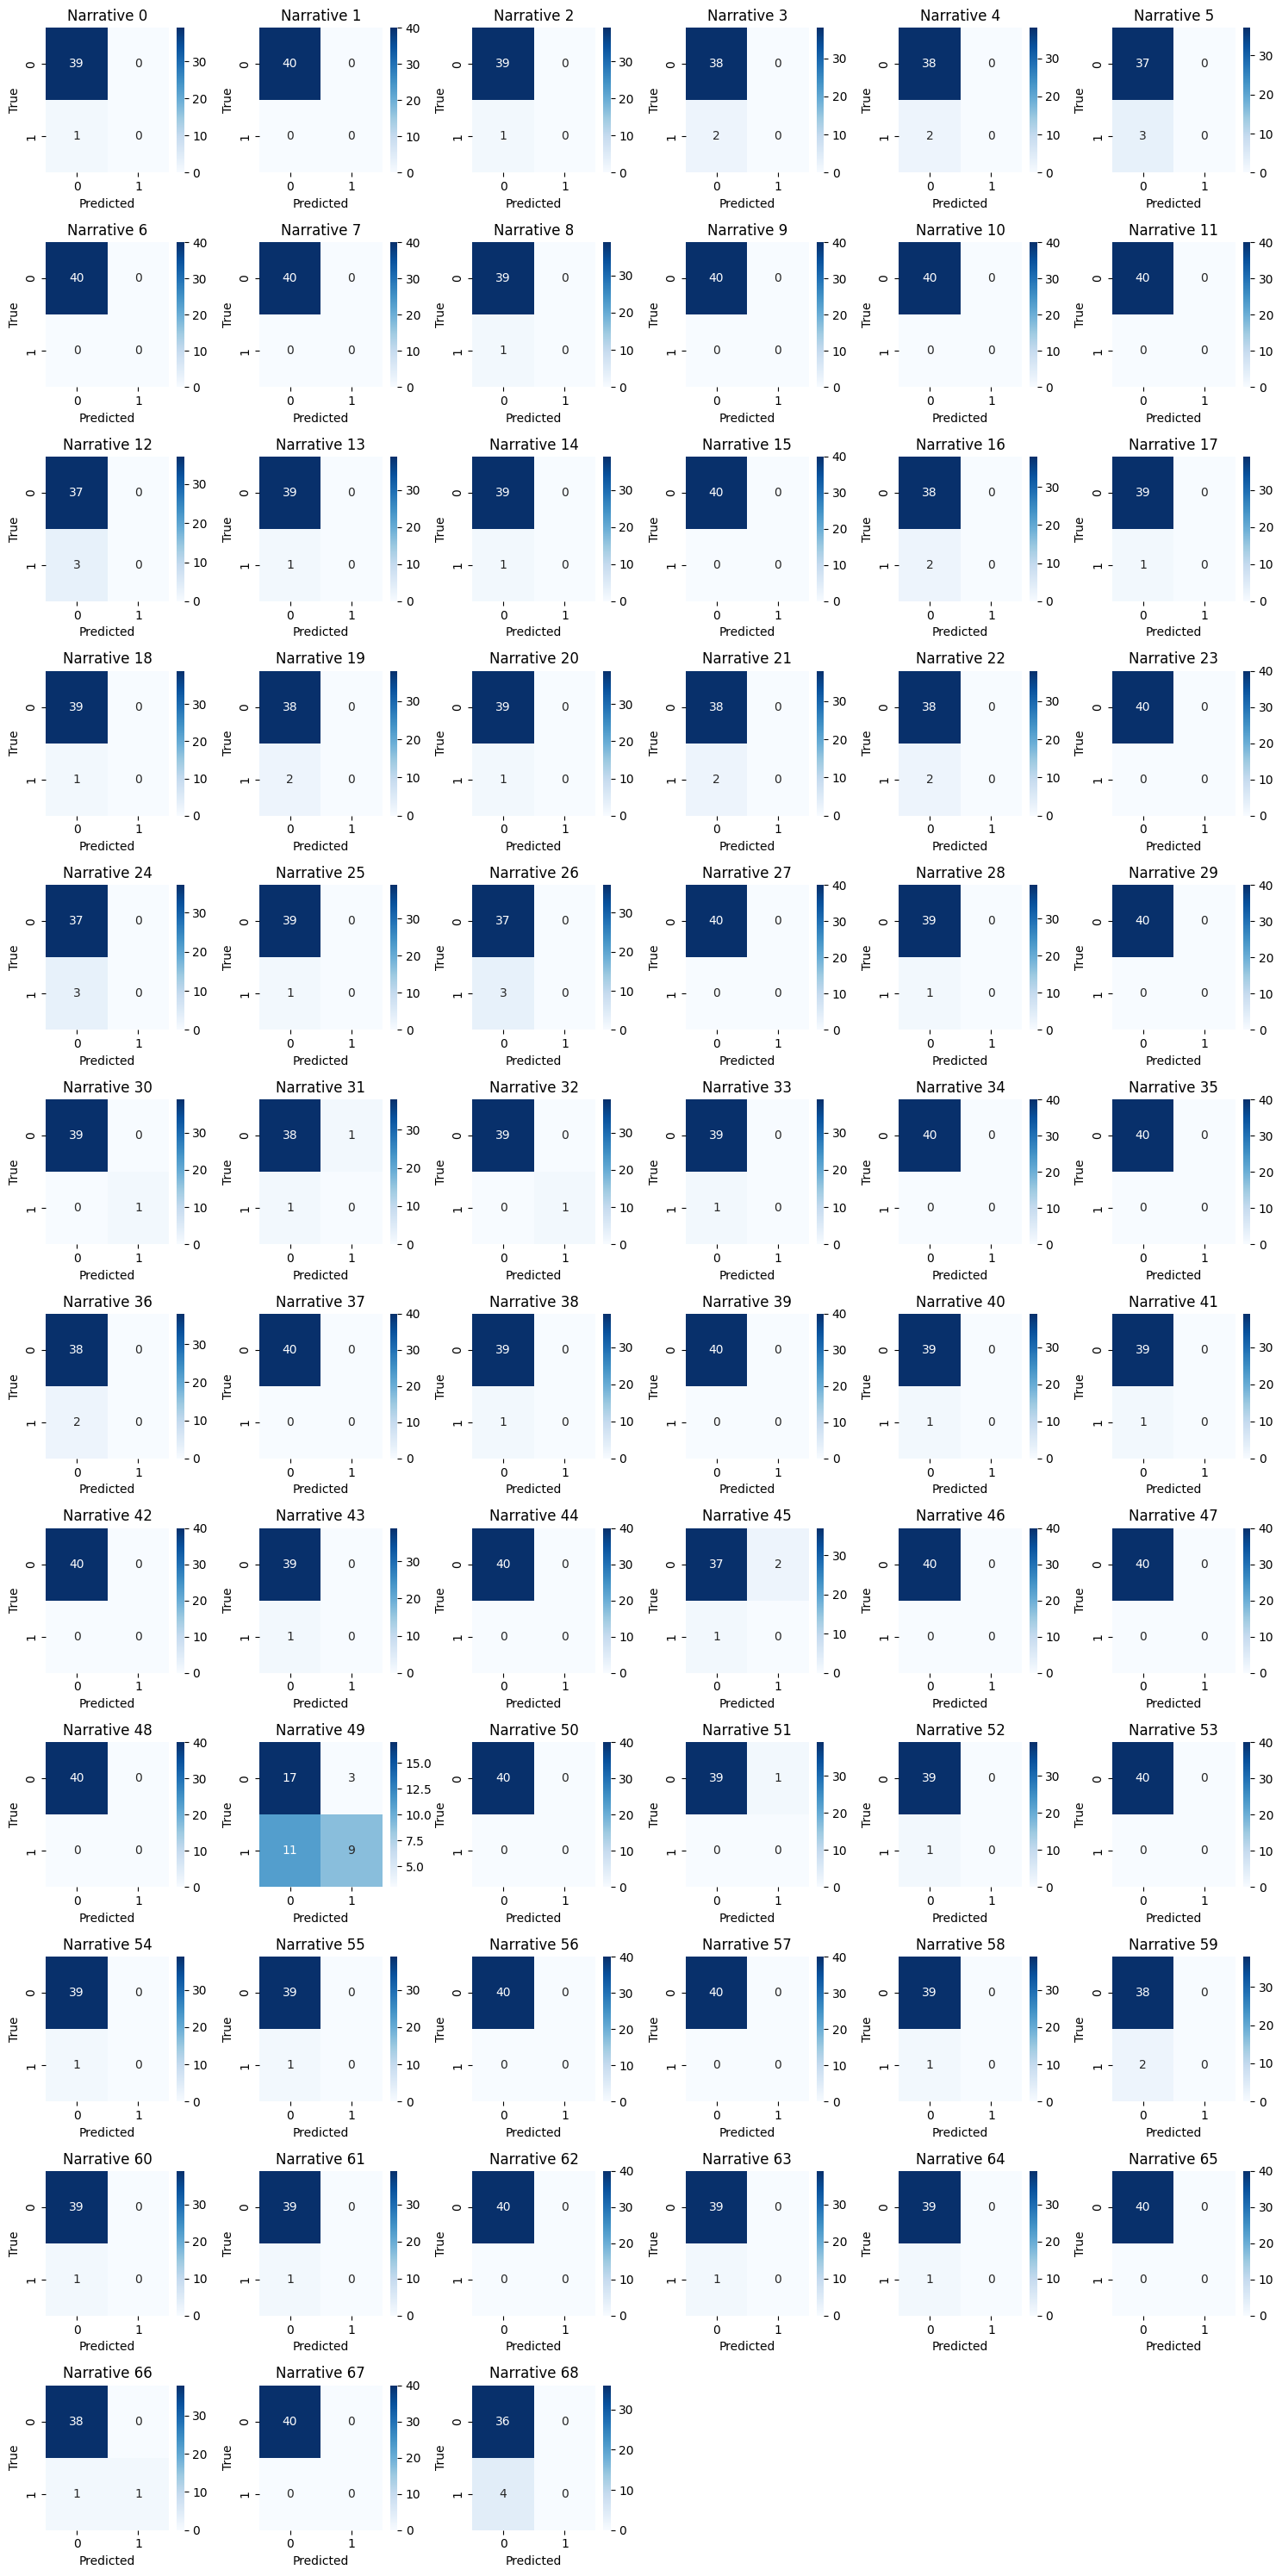

Results using Bag-Of-Words Vectorizer:
Complete Data with Bag-Of-Words:


,Narrative Index,Occurrences in Original DF,Occurrences in Train Set,Occurrences in Test Set,Occurrences in Predictions,Narrative
0,0,5,4,1,3,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: By continuing the war we risk WWIII'}"
1,1,5,5,0,2,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: NATO should/will directly intervene'}"
2,2,6,5,1,5,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: Other'}"
3,3,11,9,2,4,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: Russia will also attack other countries'}"
4,4,16,14,2,6,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Amplifying war-related fears: There is a real possibility that nuclear weapons will be employed'}"
5,5,18,15,3,2,"{'narrative': 'Blaming the war on others rather than the invader', 'subnarrative': 'Blaming the war on others rather than the invader: The West are the aggressors'}"
6,6,3,3,0,3,"{'narrative': 'Blaming the war on others rather than the invader', 'subnarrative': 'Blaming the war on others rather than the invader: Ukraine is the aggressor'}"
7,7,1,1,0,1,"{'narrative': 'Climate change is beneficial', 'subnarrative': 'Climate change is beneficial: CO2 is beneficial'}"
8,8,4,3,1,2,"{'narrative': 'Controversy about green technologies', 'subnarrative': 'Controversy about green technologies: Other'}"
9,9,2,2,0,2,"{'narrative': 'Controversy about green technologies', 'subnarrative': 'Controversy about green technologies: Renewable energy is costly'}"


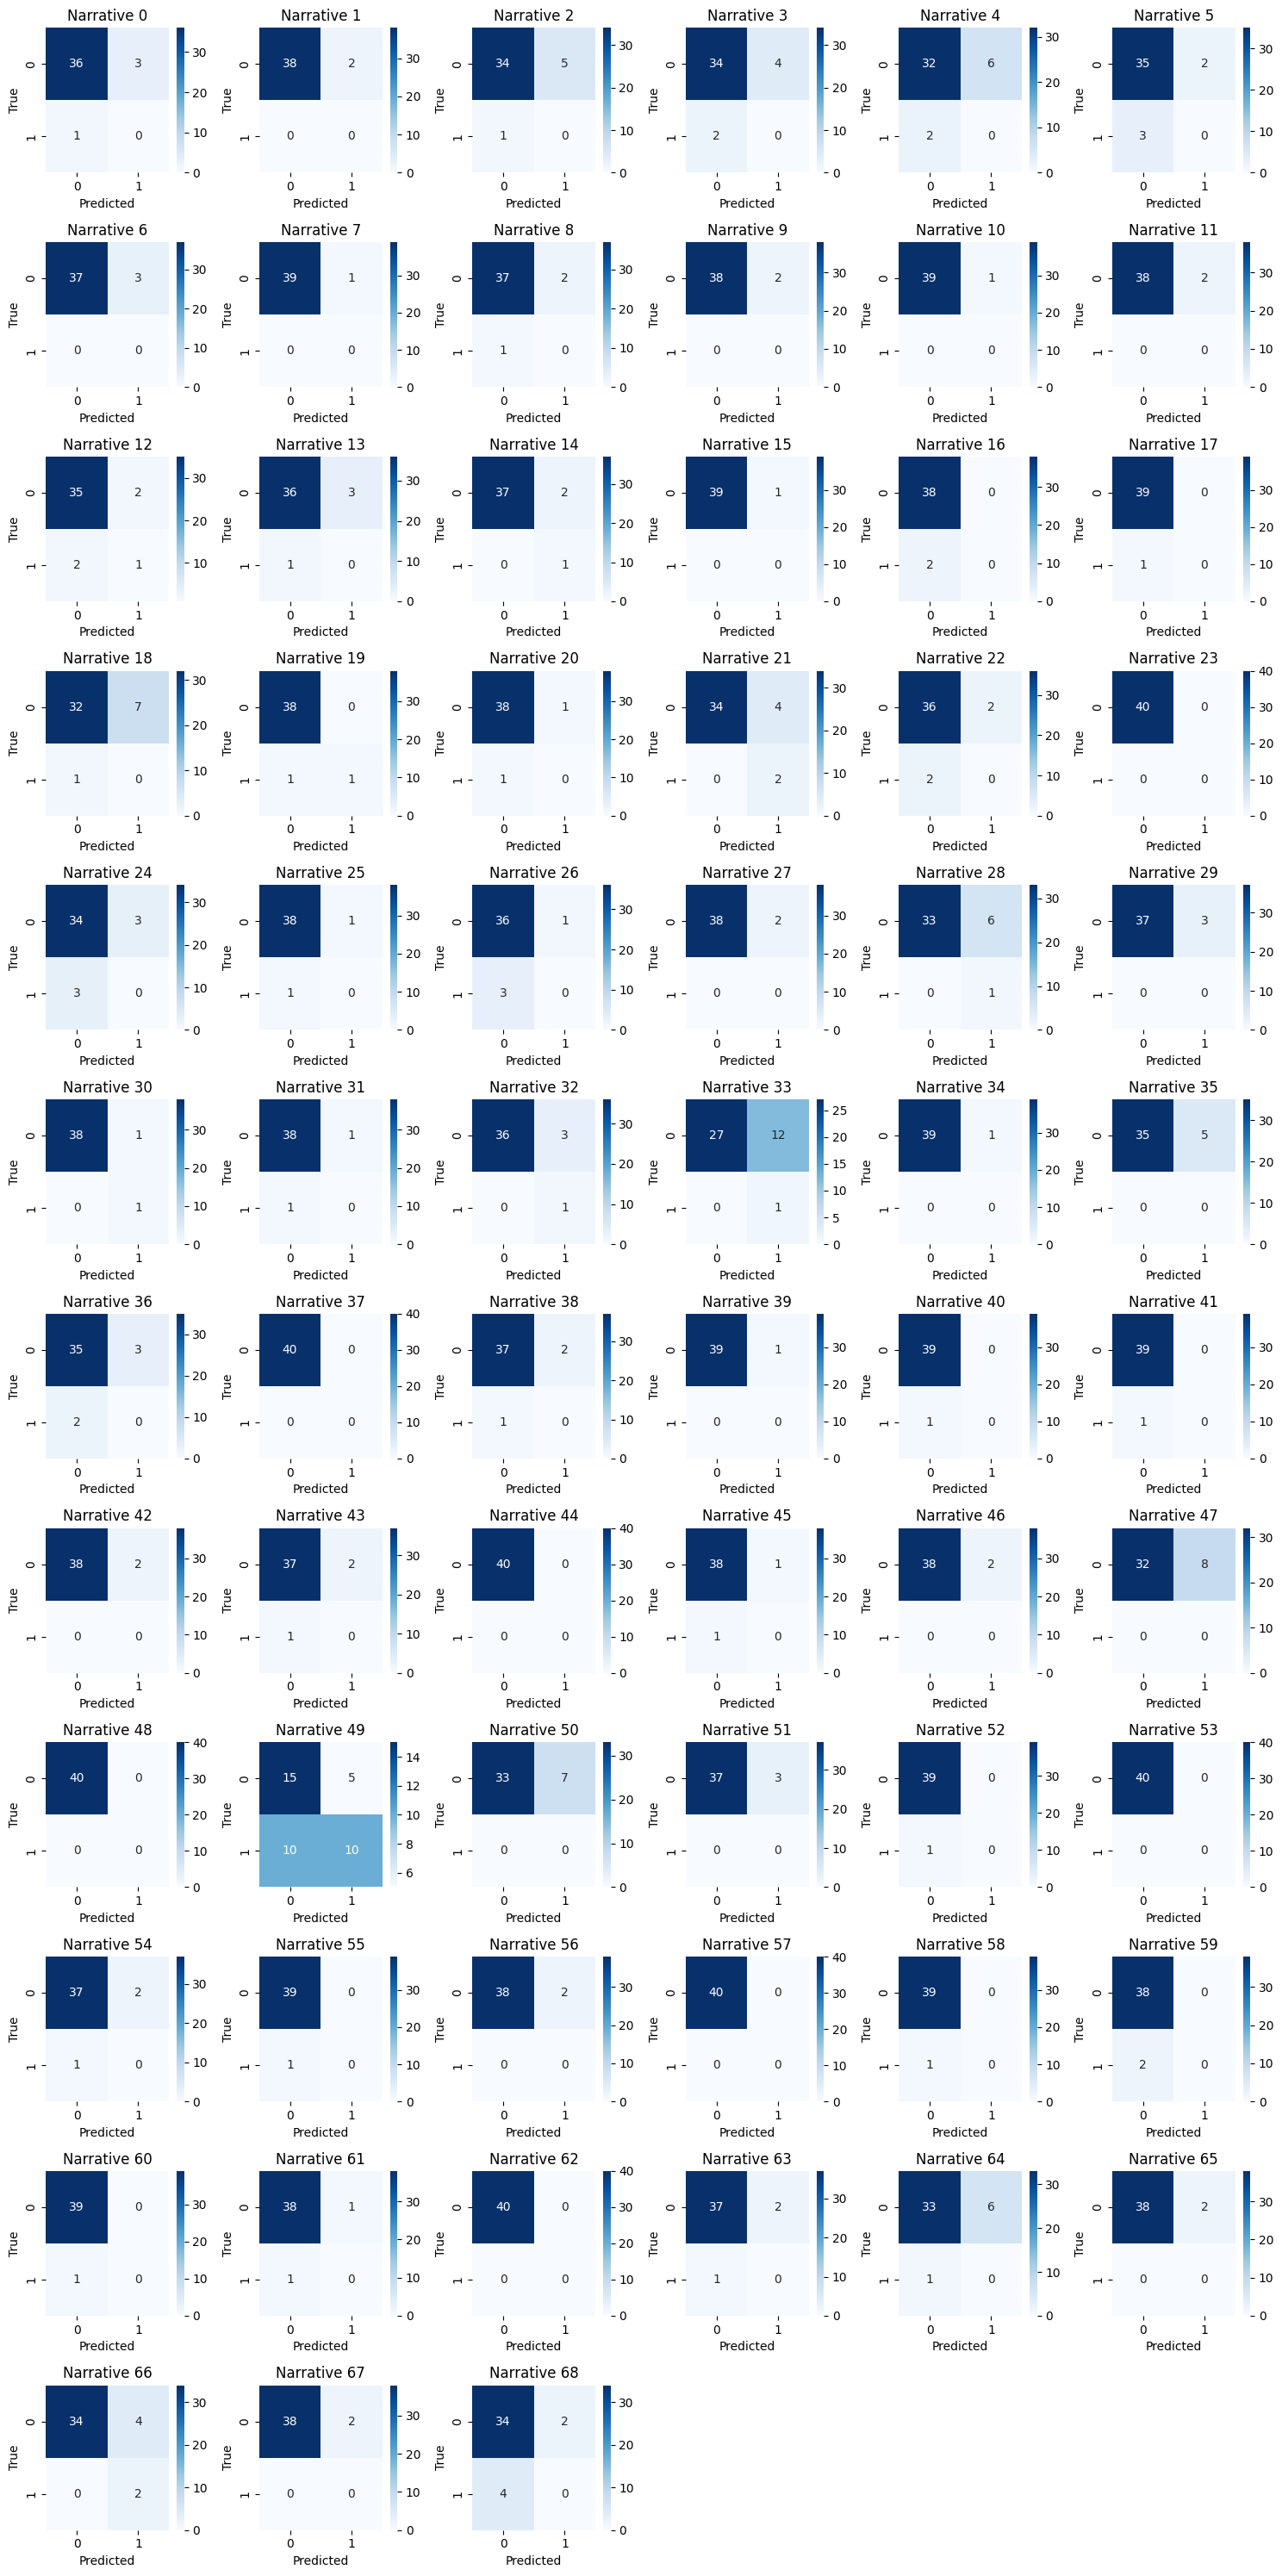

In [28]:
print("Results using TF-IDF Vectorizer:")

print("Complete Data:")
show_class_occurrences(counts_df_tfidf_compl)
show_confusion_matrix(conf_matr_tfidf_compl)


# print("Ukraine War Data:")
# show_class_occurrences(counts_df_ua)
# show_confusion_matrix(conf_matr_ua)

# print("Climate Change Data:")
# show_class_occurrences(counts_df_cc)
# show_confusion_matrix(conf_matr_cc)


print("Results using Bag-Of-Words Vectorizer:")

print("Complete Data with Bag-Of-Words:")
show_class_occurrences(counts_df_bow_compl)
show_confusion_matrix(conf_matr_bow_compl)

# print("Ukraine War Data:")
# show_class_occurrences(counts_df_bow_ua)
# show_confusion_matrix(conf_matr_bow_ua)

# print("Climate Change Data:")
# show_class_occurrences(counts_df_bow_cc)
# show_confusion_matrix(conf_matr_bow_cc)




## Result analysis

### General Considerations
- To evaluate performance, we look at the **recall, precision and f1-score**

- We argue that a **high recall is more relevant** for this task. Given the example of assigning articles on X (formerly twitter)  to certain narratives to flag to it like "A problematic narrative x might be contained in this article", we are more interested in actually finding all relevant narratives.
- Therefore, if we optimise our results, we will do it with respect to recall.

- From the occurences tables, we identify class imbalance as a big problem, and many classes only have very few instances. 
- Especially {narrative:"other, subnarrative:"Other"} is highly overrepresented in the data - it has 97 occurences in the data
- Other narratives are strongly underrepresented, only having a single instance.

- Further, we notice that the results vary significantly with the seed. This is a further indicator, that the general amount of data might not be sufficient.

### Metric Calculation

**Macro Average**

- Macro-Avg scores do not consider class frequency, and therefore treat each class independently.
- We note, that the metrics computed with macro average are generally very poor.
- This is due to multiple reasons:
    - task complexity with a large output space in terms of class number and multiple labels that can apply to an article
    - the class distribution is highly unbalanced
    - with only using the english data, we have a quite limited dataset size, especially when considering the task complexity
    - the method of one-vs-rest classification with SVMs likely lacks the suitable capacity for this task

**Weighted Average**

- Weigthed-Avg scores take the support into account. Classes with more samples contribute more to the overall score.
- The metrics computed with weighted average generally look very much better, since underrepresented classes, for which the model has almost no chance of learning them, are not weighted equally

### Confusion Matrix and Occurances Table
- For each label, we show the confusion matrix and give an overview of its occurences in the data and the predictions.
- This reveals, that the model almost purely predicts class 'Other-Other', while other narratives are ignored completly.
- This is a huge issue.

### Splitting data into ukraine war and climate change
- Treating ukraine war and climate change data separately intensifies the problem of the imbalanced data set and predictions
- This holds especially for the climate change set, indicating that the imbalance is even worse in this subset.

### Representation Method
- Compared to using tf-idf as data representation method, with bag-of-words, the model generally predicts classes more often.
- With this, we also get some correct predicitions apart from the 'Other-Other' class.
- However, still the trend to predicting the 'Other-Other' class persists

### Further Task Specific Problems
When training the SVM, a user warning occurs: "Label not :NUMBER: is present in all training examples". This is sklearns weird way of saying that there are label indices that do not occur in any of the training data instances. This happens the following way:
- The unique labels are generated using the whole dataset
- After making the train-test-split, it is likely that classes that have a low representation did not make it into the training set

The result of this is that the model obviously can't learn how to predict this class, resulting in no correct predictions for it. This is a problem specific problem, since in multi-class classification (xx classes), it frequently occurs that some classes are represented a lot and others very rarely.

### Solution Approaches
Underrepresented classes with only very few instances make the problem very hard to handle, especially if some classes are not represented at all in the test set. Possible strategies would include

- Stratification at the train-test-split level could resolve this problem by ensuring the distribution of the classes is the same in train and test
    - With single occurances of classes, this is not possible since at least two occurances per class are necessary
- Using SMOTE to create synthetic training instances for underrepresented classes
    - For this as well, more than one occurance per class is necessary since the synthetic examples are generated using the "nearest neighbors" of that class
- Another way of dealing with the problem is to copy instances of classes that only occur once and then using stratification. Since that would lead to leakage from the training into the test data, this is worse than not addressing it since that way, the performance would be artificially raised.

Another, straight-forward way would be to collect more data in general, using also the data sets from different languages.

Addressing the mentioned problems further will be a task for the final project submission.
